In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Initial imports
import pydot
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [4]:
# Read the file
url = "https://storage.googleapis.com/crude_oil_projection/Cleaned_Crude_Oil_Dataset.csv"

df  = pd.read_csv(url)
df .head()

,Date,U.S. Field Production of Crude Oil (1k Bar.),Product Supplied of Crude Oil and Petroleum Products (1k Bar.),Gross Inputs to Refineries (1k Bar./Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operating Crude Oil Distillation Capacity (1k Bar./Day),Idle Crude Oil Distillation Capacity (1k Bar./Day),Percent Utilization of Refinery Operable Capacity,"Cushing, OK Crude Oil Future Contract ($/Bar.)","Cushing, OK WTI Spot Price FOB ($/Bar.)"
0,Apr-1986,265917,478339,12603,15473,14550,923,81.5,12.8,12.8
1,Apr-1987,254945,495706,12637,15565,14870,695,81.2,18.6,18.7
2,Apr-1988,248629,496816,13346,15888,14986,902,84.0,17.9,17.9
3,Apr-1989,233147,498719,13123,15687,14944,743,83.7,20.9,21.1
4,Apr-1990,222215,503351,13250,15582,14827,754,85.0,18.6,18.4


In [5]:
# Rename columns
df.columns = ["Date", "Total_Production", "Product_Supplied", "Refinery_Input", "Operable_Dist_Capacity", "Operating_Dist_Capacity", "Idle_Dist_Capacity", "Percent_Util", "Future_Price", "Spot_Price"]
df.head()

,Date,Total_Production,Product_Supplied,Refinery_Input,Operable_Dist_Capacity,Operating_Dist_Capacity,Idle_Dist_Capacity,Percent_Util,Future_Price,Spot_Price
0,Apr-1986,265917,478339,12603,15473,14550,923,81.5,12.8,12.8
1,Apr-1987,254945,495706,12637,15565,14870,695,81.2,18.6,18.7
2,Apr-1988,248629,496816,13346,15888,14986,902,84.0,17.9,17.9
3,Apr-1989,233147,498719,13123,15687,14944,743,83.7,20.9,21.1
4,Apr-1990,222215,503351,13250,15582,14827,754,85.0,18.6,18.4


In [6]:
# Get month and Year from Date
df["Year"] = pd.DatetimeIndex(df["Date"]).year
df["Month"] = pd.DatetimeIndex(df["Date"]).month

# Reorder Columns 
df = df[["Date", "Year", "Month", "Total_Production", "Product_Supplied", "Refinery_Input", "Operable_Dist_Capacity", "Operating_Dist_Capacity", "Idle_Dist_Capacity", "Percent_Util", "Future_Price", "Spot_Price"]]

# Sorting DataFrame by Year and Month
df.sort_values(["Year", "Month"], ascending=[True, True], inplace=True)

# DataFrame without index
df.reset_index(drop=True, inplace=True)
df.head()

,Date,Year,Month,Total_Production,Product_Supplied,Refinery_Input,Operable_Dist_Capacity,Operating_Dist_Capacity,Idle_Dist_Capacity,Percent_Util,Future_Price,Spot_Price
0,Jan-1986,1986,1,283248,498728,12583,15459,14639,820,81.4,23.0,22.9
1,Feb-1986,1986,2,256855,453209,12068,15485,14538,947,77.9,15.5,15.5
2,Mar-1986,1986,3,279413,504565,11759,15485,14517,968,75.9,12.6,12.6
3,Apr-1986,1986,4,265917,478339,12603,15473,14550,923,81.5,12.8,12.8
4,May-1986,1986,5,273964,495789,13314,15484,14805,679,86.0,15.3,15.4


In [7]:
print("The shape of our DataFrame is:", df.shape)

The shape of our DataFrame is: (430, 12)


In [8]:
# Descriptive statistics for each column
df.describe()

,Year,Month,Total_Production,Product_Supplied,Refinery_Input,Operable_Dist_Capacity,Operating_Dist_Capacity,Idle_Dist_Capacity,Percent_Util,Future_Price,Spot_Price
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,2003.418605,6.476744,220299.755814,574218.216279,15007.913953,16841.562791,16419.065116,422.527907,89.159767,44.572326,44.558372
std,10.355527,3.446990,59441.362987,45528.327895,1238.984141,1161.536555,1210.491590,337.887670,4.918490,28.698790,28.683308
min,1986.000000,1.000000,119208.000000,436455.000000,11759.000000,15028.000000,14375.000000,32.000000,70.200000,11.300000,11.300000
25%,1994.250000,3.250000,173878.250000,537078.500000,14049.250000,15686.250000,15117.000000,158.250000,86.000000,19.900000,19.900000
50%,2003.000000,6.000000,202056.500000,579533.000000,15093.500000,16764.000000,16564.000000,321.500000,89.500000,33.050000,33.300000
75%,2012.000000,9.000000,255772.250000,610163.500000,15803.750000,17736.000000,17227.500000,617.750000,92.700000,63.500000,63.650000
max,2021.000000,12.000000,400219.000000,671648.000000,18041.000000,18976.000000,18698.000000,2651.000000,99.900000,134.000000,133.900000


## # Preprocess the Data

In [9]:
# Define the features and target set.
X = df.drop(["Date", "Spot_Price", "Future_Price"], axis = 1)
y = np.array(df["Spot_Price"])

# Saving feature names for later use
X_list = list(X.columns)

# Convert to numpy array
X = np.array(X)

## # Training and Testing Sets

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [11]:
print("Training Features Shape:", X_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Testing Labels Shape:", y_test.shape)

Training Features Shape: (322, 9)
Training Labels Shape: (322,)
Testing Features Shape: (108, 9)
Testing Labels Shape: (108,)


In [12]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## # Fit the Random Forest Model

In [13]:
# Create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

## # Make Predictions on the Test Set

In [14]:
# Making predictions using the testing data
y_pred = rf_model.predict(X_test_scaled)

## # Evaluate the Model

In [15]:
# Calculate the mean absolute (MAE), mean squared (MSE), and root mean squared errors (RMSE)
print(f"Mean Absolute Error(MAE): {metrics.mean_absolute_error(y_test, y_pred):.2f}")

Mean Absolute Error(MAE): 4.25


In [16]:
# The absolute errors (MAE)
errors = abs(y_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print("Accuracy:", round(accuracy, 2), "%.")

Accuracy: 88.64 %.


## # Visualizing a Single Decision Tree

In [17]:
# Pull out one tree from the forest
tree = rf_model.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = "tree.dot", feature_names = X_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file("tree.dot")

# Write graph to a png file
graph.write_png("tree.png")

## # The reduced size tree
(To make things easier: limit the depth of trees in the forest to produce an understandable image)

In [18]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train_scaled, y_train)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = "small_tree.dot", feature_names = X_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file("small_tree.dot")
graph.write_png("small_tree.png");

# # Rank the Importance of Features

In [19]:
# Get numerical feature importances
importances = list(rf_model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print("Variable: {:10} Importance: {}".format(*pair)) for pair in feature_importances];

Variable: Operable_Dist_Capacity Importance: 0.57
Variable: Year       Importance: 0.34
Variable: Operating_Dist_Capacity Importance: 0.03
Variable: Idle_Dist_Capacity Importance: 0.02
Variable: Month      Importance: 0.01
Variable: Total_Production Importance: 0.01
Variable: Product_Supplied Importance: 0.01
Variable: Refinery_Input Importance: 0.01
Variable: Percent_Util Importance: 0.01


### Visualization - the Importance of Features

In [20]:
# Set the style
plt.style.use("fivethirtyeight")

# list of x locations for plotting
x_values = list(range(len(importances)))

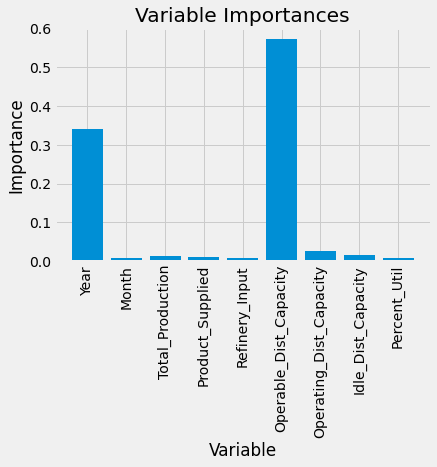

In [21]:
# Make a bar chart
plt.bar(x_values, importances, orientation = "vertical")

# Tick labels for x axis
plt.xticks(x_values, X_list, rotation="90")

# Axis labels and title
plt.ylabel("Importance"); plt.xlabel("Variable"); plt.title("Variable Importances");

# # Make a Random Forest with only the two most important variables

In [22]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

In [23]:
# Extract the two most important features
important_indices = [X_list.index("Operable_Dist_Capacity"), X_list.index("Year")]
train_important = X_train_scaled[:, important_indices]
test_important = X_test_scaled[:, important_indices]

In [24]:
# Train the random forest
rf_most_important.fit(train_important, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [25]:
# Make predictions and determine the error
y_pred = rf_most_important.predict(test_important)

In [26]:
# Calculate the mean absolute (MAE), mean squared (MSE), and root mean squared errors (RMSE)
print(f"Mean Absolute Error(MAE): {metrics.mean_absolute_error(y_test, y_pred):.2f}")

Mean Absolute Error(MAE): 3.56


In [27]:
# The absolute errors (MAE)
errors = abs(y_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape

print("Accuracy:", round(accuracy, 2), "%.")

Accuracy: 90.63 %.


## # Visualizations

In [28]:
# Dates of training values
months = X[:, X_list.index("Month")]
years = X[:, X_list.index("Year")]

# List and then convert to datetime object
dates = [str(int(year)) + "-" + str(int(month)) for year, month in zip(years, months)]
dates = [dt.datetime.strptime(date, "%Y-%m") for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {"date": dates, "actual": y})

# Dates of predictions
months = X_test[:, X_list.index("Month")]
years = X_test[:, X_list.index("Year")]

In [29]:
# Column of dates
test_dates = [str(int(year)) + "-" + str(int(month)) for year, month in zip(years, months)]

# Convert to datetime objects
test_dates = [dt.datetime.strptime(date, "%Y-%m") for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {"date": test_dates, "prediction": y_pred})

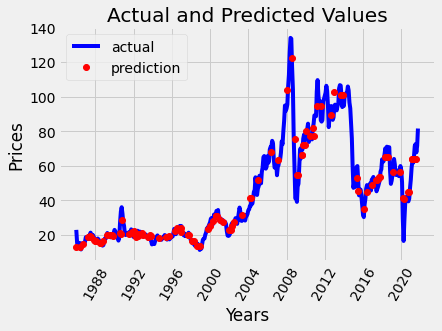

In [30]:
# Plot the actual values
plt.plot(true_data["date"], true_data['actual'], "b-", label = "actual")

# Plot the predicted values
plt.plot(predictions_data["date"], predictions_data["prediction"], "ro", label = "prediction")
plt.xticks(rotation = "60"); 
plt.legend()

# Graph labels
plt.xlabel("Years"); plt.ylabel("Prices"); plt.title('Actual and Predicted Values');